In [114]:
%matplotlib inline


import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters


# imports and settings for plots
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr 
import seaborn as sns
sns.set_style("whitegrid")

#### Задача:
1. Воспроизведите график числа рекламных событий по дням. 
2. Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло. 
3. Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики. Иными словами, предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день. Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике? 

Предложите вариант кода, который решает эту задачу. Реализовывать логику нотификации не нужно, только поиск аномального дня, часа, пятиминутки в данных рекламной статистики. 

Немного дополнительной информации о структуре рекламы ВКонтакте. 
Есть две основные группы рекламодателей: агентства и клиенты. 
Агентствами являются рекламные кабинеты юридических лиц. Среди клиентов же существуют как клиенты этих самых агентств, так и автономные рекламные кабинеты физических лиц, над которыми нет агентств. 
Рекламные кампании — это наборы рекламных объявлений. 
Они есть в каждом кабинете. 

Описание данных:

- time — время взаимодействия пользователя с рекламой в формате UnixTime;
- event — тип взаимодействия (click — клик на объявление, view — показ объявления, report — жалоба на объявление);
- ad_cost_type — тип трат рекламного объявления (CPM — траты за 1000 показов, CPC — траты за клик);
- has_video — наличие видео в объявлении (0 — нет, 1 — есть);
- agency_union_id — id рекламного агентства (если рекламный кабинет принадлежит физическому лицу, то ячейка будет заполнена значением 'no_agency');
- client_union_id — id рекламного клиента;
- campaign_union_id — id рекламной кампании;
- ad_id — id рекламного объявления;
- platform — платформа, с которой пользователь взаимодействовал с рекламой (web — веб-версия, mvk — мобильная версия, iphone — IOS-приложение, android — Android-приложение, wphone — Windows Phone-приложение).

Считаем первые n-строк, чтобы не загружать весь датасет в память целиком, посмотрим на данные и выберем нужные параметры для считывания.

In [115]:
path = 'data/vk_test_data.csv'
df = pd.read_csv(path, 
                 nrows = 5)

In [116]:
df

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
0,1.554744e+09,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08
1,1.555103e+09,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12
2,1.555403e+09,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16
3,1.554822e+09,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09
4,1.554967e+09,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11


In [194]:
df = pd.read_csv(path, 
                 sep=",",
                 dtype={'time': 'uint32',
                        'has_video': 'bool'})

In [195]:
df['time_from_timestamp'] = pd.to_datetime(df.time,unit='s')

In [196]:
'''
# auxillary method, to check if value is in range
vals = [1554744145, np.int32(2), np.int64(1), np.float64(0)]
[(e, type(e), isinstance(e, (int, np.integer))) for e in vals]
''';

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122097 entries, 0 to 122096
Data columns (total 11 columns):
time                   122097 non-null uint32
event                  122097 non-null object
ad_cost_type           122097 non-null object
has_video              122097 non-null bool
agency_union_id        122097 non-null object
client_union_id        122097 non-null object
campaign_union_id      122097 non-null object
ad_id                  122097 non-null object
platform               122097 non-null object
date                   122097 non-null object
time_from_timestamp    122097 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), object(8), uint32(1)
memory usage: 9.0+ MB


In [198]:
df.head(10)

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
0,1554744145,report,CPM,False,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08,2019-04-08 17:22:25
1,1555103458,click,CPM,False,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12,2019-04-12 21:10:58
2,1555402601,click,CPM,False,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16,2019-04-16 08:16:41
3,1554822479,click,CPM,False,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
4,1554966717,click,CPM,False,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11,2019-04-11 07:11:57
5,1555418913,view,CPC,False,no_agency,client_265,campaign_13516,ad_13517,android,2019-04-16,2019-04-16 12:48:33
6,1555146351,report,CPM,False,no_agency,client_22021,campaign_34637,ad_34651,mvk,2019-04-13,2019-04-13 09:05:51
7,1554503043,view,CPM,False,agency_155,client_105617,campaign_106015,ad_106015,iphone,2019-04-05,2019-04-05 22:24:03
8,1554940634,view,CPM,False,no_agency,client_264,campaign_13491,ad_13513,android,2019-04-10,2019-04-10 23:57:14
9,1554719466,view,CPM,False,no_agency,client_1728,campaign_19254,ad_19255,android,2019-04-08,2019-04-08 10:31:06


#### Lineplot of advertisment distribution by days.

In [199]:
count_adv_by_day = df.groupby('date', as_index=False).\
agg({'event':'count'})\
.rename(columns = {'event':'event_count'})\


# need it for correct usage of date formatter in plot
count_adv_by_day['date'] = pd.to_datetime(count_adv_by_day.date, format='%Y-%m-%d')

count_adv_by_day.sort_values(by = 'date', ascending=True, inplace=True)

In [200]:
count_adv_by_day

,date,event_count
0,2019-04-01,5172
1,2019-04-02,5269
2,2019-04-03,5357
3,2019-04-04,5108
4,2019-04-05,5305
5,2019-04-06,3955
6,2019-04-07,4091
7,2019-04-08,8902
8,2019-04-09,7963
9,2019-04-10,7098


In [201]:
def y_fmt(tick_val, pos):
    if tick_val > 1000000:
        val = int(tick_val)/1000000
        return (str(val) + "M")
    elif tick_val > 1000:
        val = int(int(tick_val) / 1000)
        return (str(val) + "k")
    else:
        return tick_val

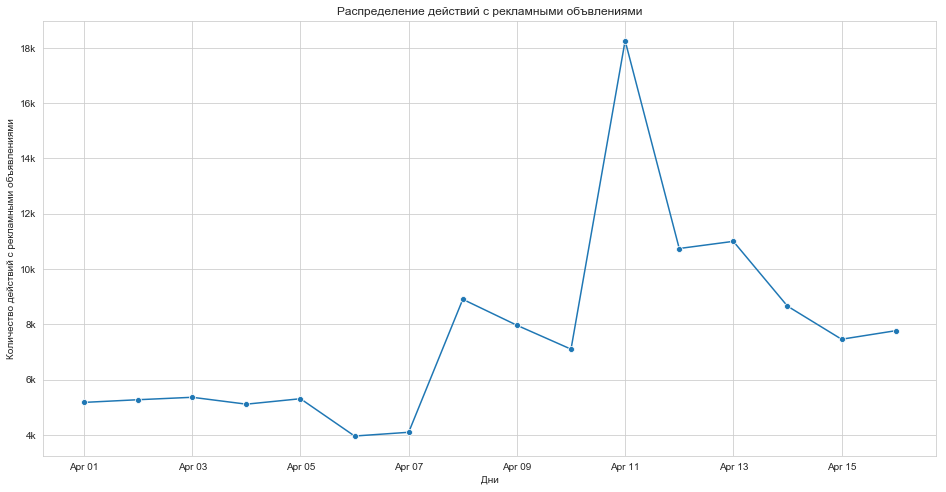

In [202]:
ax = sns.lineplot(x = 'date', 
                  y = 'event_count', 
                  marker="o",
                  data = count_adv_by_day)

ax.figure.set_size_inches(16, 8)
ax.set_title('Распределение действий с рекламными объвлениями')
ax.set_xlabel('Дни')
ax.set_ylabel('Количество действий с рекламными объявлениями')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

yfmt = tkr.FuncFormatter(y_fmt) 
ax.yaxis.set_major_formatter(yfmt)

#### Splash reasons?

Причин такого всплеска может быть несколько, в первую очередь это может быть какой-либо технический сбой, затем это может быть какая-либо рекламная акция или же какое-либо произошедшее массовое событие.

В первую очередь - проверим гипотезу о техническом сбое.

Для этого попробуем сначала проанализировать каких платформ это коснулось больше всего, а затем будем продвигаться по рекламными кампаниям вверх к агенствам.

In [203]:
# check for NAs for safety
df.isna().sum()

time                   0
event                  0
ad_cost_type           0
has_video              0
agency_union_id        0
client_union_id        0
campaign_union_id      0
ad_id                  0
platform               0
date                   0
time_from_timestamp    0
dtype: int64

In [286]:
df.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
0,1554744145,report,CPM,False,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08,2019-04-08 17:22:25
1,1555103458,click,CPM,False,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12,2019-04-12 21:10:58
2,1555402601,click,CPM,False,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16,2019-04-16 08:16:41
3,1554822479,click,CPM,False,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
4,1554966717,click,CPM,False,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11,2019-04-11 07:11:57


In [335]:
for column in df.drop(['time', 'date', 'time_from_timestamp'], axis = 1): 
    print(df[column].value_counts()[:3])

view      87975
click     28639
report     5483
Name: event, dtype: int64
CPC    74202
CPM    47895
Name: ad_cost_type, dtype: int64
False    121429
True        668
Name: has_video, dtype: int64
agency_2     50796
no_agency    47267
agency_33     1813
Name: agency_union_id, dtype: int64
client_47270    47739
client_47269     2285
client_99583     1732
Name: client_union_id, dtype: int64
campaign_49554    47739
campaign_47269     1867
campaign_5822      1012
Name: campaign_union_id, dtype: int64
ad_49554    27500
ad_49556     8218
ad_49560     7496
Name: ad_id, dtype: int64
android    83312
iphone     16628
web        14108
Name: platform, dtype: int64


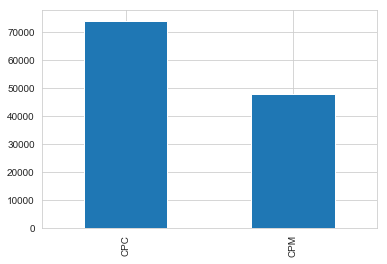

In [295]:
df.ad_cost_type.value_counts().plot(kind='bar')

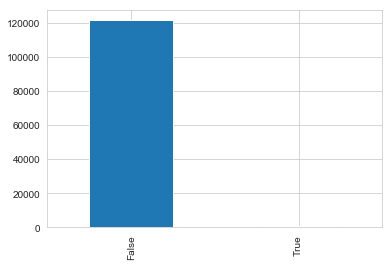

In [296]:
df.has_video.value_counts().plot(kind='bar')

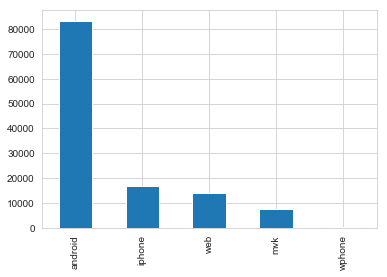

In [297]:
df.platform.value_counts().plot(kind='bar')

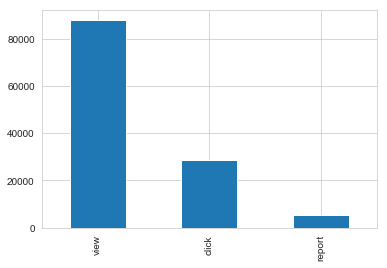

In [298]:
df.event.value_counts().plot(kind='bar')

In [299]:
1827+362+2983

5172

In [300]:
3411+750+255+733+23

5172

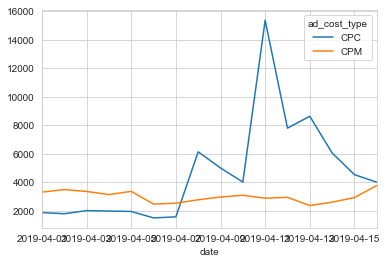

In [336]:
adcost_data = df.pivot_table(index='date',
                                   columns='ad_cost_type',
                                   values='event',
                                   aggfunc='count')
adcost_data.plot()

In [339]:
events_data = df.pivot_table(index='date',
                                   columns='event',
                                   values='platform',
                                   aggfunc='count').reset_index()

count_by_platform = df.pivot_table(index='date',
                                   columns='platform',
                                   values='event',
                                   aggfunc='count').reset_index()

'''
.agg({'platform' : 'count',
     'event' : ['min', 'max', 'mean', 'count']     
     })
'''

events_data = events_data.merge(adcost_data, how = 'outer',on='date')

events_data = events_data.merge(count_by_platform, how = 'outer',on='date')

events_data

,date,click,report,view,CPC,CPM,android,iphone,mvk,web,wphone
0,2019-04-01,1827,362,2983,1866,3306,3411,750,255,733,23
1,2019-04-02,1898,366,3005,1786,3483,3446,807,275,717,24
2,2019-04-03,1837,304,3216,2005,3352,3482,875,251,736,13
3,2019-04-04,1871,368,2869,1975,3133,3343,813,235,695,22
4,2019-04-05,2188,432,2685,1947,3358,3491,827,309,656,22
5,2019-04-06,1577,300,2078,1492,2463,2656,612,202,471,14
6,2019-04-07,1510,297,2284,1567,2524,2712,638,229,493,19
7,2019-04-08,1545,311,7046,6134,2768,5530,1662,644,1049,17
8,2019-04-09,1784,351,5828,5002,2961,5105,1284,560,993,21
9,2019-04-10,1909,347,4842,4014,3084,4556,1141,466,905,30


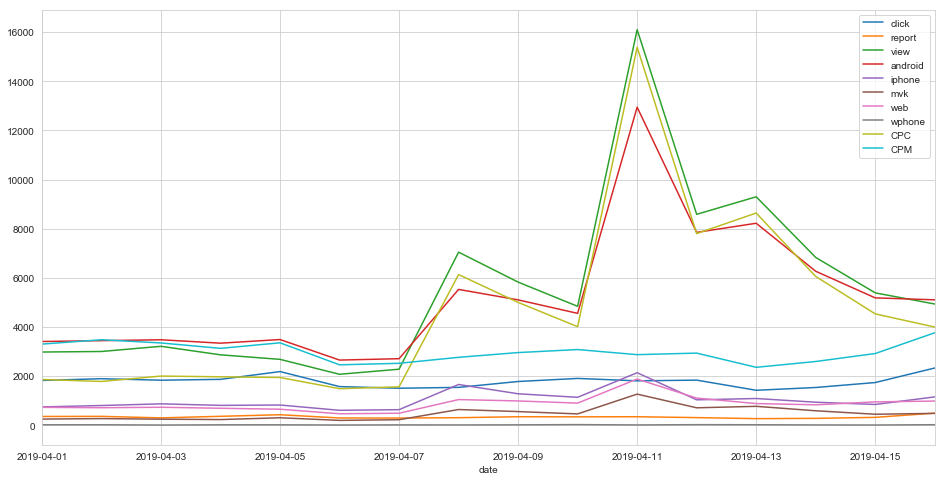

In [338]:
events_data.plot(x = 'date',kind = 'line', figsize=(16,8))

Как видно из таблицы, 11 апреля, количество событий view резко выросло.

Распределение роста по самым популярным платформам составило примерно 2-3 раза.

In [ ]:
#
# а может быть перепутаны местами CPC and CPM !!!
#

In [313]:
df[(df.date == '2019-04-05') & (df.event == 'view')][['event', 'ad_cost_type']].head()

,event,ad_cost_type
7,view,CPM
33,view,CPM
77,view,CPC
110,view,CPC
119,view,CPC


In [325]:
df[(df.date == '2019-04-11') & (df.event == 'view')][['event', 'ad_cost_type']].head()

,event,ad_cost_type
16,view,CPC
19,view,CPC
22,view,CPC
25,view,CPC
43,view,CPC


Не подвердилось.

Проверим исходный набор данных на дупликаты и попробуем посмотреть на день c максимальным количеством view "вблизи".

In [246]:
# duplicates
df_duplicates = df[df.duplicated()]
df_duplicates.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
2234,1554977507,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 10:11:47
3241,1554923375,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,iphone,2019-04-10,2019-04-10 19:09:35
4416,1554923455,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-10,2019-04-10 19:10:55
5290,1554988297,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 13:11:37
6492,1555158128,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-13,2019-04-13 12:22:08


In [247]:
# get unique days, may be times?

In [332]:
# drop has video, cause it contains only false
for column in df_duplicates.drop(['time','time_from_timestamp','has_video'], axis = 1):
    #print(column)
    print(df_duplicates[column].value_counts(ascending=False)[:3])

view      1110
click       25
report       1
Name: event, dtype: int64
CPC    1110
CPM      26
Name: ad_cost_type, dtype: int64
agency_2      1109
no_agency       24
agency_543       1
Name: agency_union_id, dtype: int64
client_47270    1108
client_21614      12
client_21149       5
Name: client_union_id, dtype: int64
campaign_49554    1108
campaign_32662      12
campaign_28332       2
Name: campaign_union_id, dtype: int64
ad_49554    921
ad_49556    103
ad_49560     68
Name: ad_id, dtype: int64
android    1083
iphone       26
web          14
Name: platform, dtype: int64
2019-04-11    617
2019-04-13    192
2019-04-12    118
Name: date, dtype: int64


In [239]:
df[(df.date == '2019-04-11')].shape

(18259, 11)

In [257]:
df[(df.ad_id == 'ad_49554') & (df.date == '2019-04-11')].head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
19,1555011001,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 19:30:01
22,1554977283,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 10:08:03
43,1554981349,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 11:15:49
44,1554982660,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 11:37:40
53,1554979803,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 10:50:03


In [258]:
df[(df.ad_id == 'ad_49556') & (df.date == '2019-04-11')].head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
47,1554993752,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49556,android,2019-04-11,2019-04-11 14:42:32
48,1554983958,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49556,android,2019-04-11,2019-04-11 11:59:18
76,1554980542,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49556,android,2019-04-11,2019-04-11 11:02:22
107,1555009812,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49556,android,2019-04-11,2019-04-11 19:10:12
158,1555003188,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49556,android,2019-04-11,2019-04-11 17:19:48


In [244]:
df_splash_day = df[df.date == '2019-04-11']
df_splash_day.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
4,1554966717,click,CPM,False,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11,2019-04-11 07:11:57
16,1555012937,view,CPC,False,agency_2,client_47269,campaign_47269,ad_47269,android,2019-04-11,2019-04-11 20:02:17
19,1555011001,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 19:30:01
22,1554977283,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 10:08:03
25,1554964311,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49560,android,2019-04-11,2019-04-11 06:31:51


In [334]:
for column in df_splash_day.drop(['time', 'date', 'time_from_timestamp'], axis = 1): 
    print(df_splash_day[column].value_counts()[:3])

view      16097
click      1811
report      351
Name: event, dtype: int64
CPC    15383
CPM     2876
Name: ad_cost_type, dtype: int64
False    18227
True        32
Name: has_video, dtype: int64
agency_2      14035
no_agency      2691
agency_158      105
Name: agency_union_id, dtype: int64
client_47270    13941
client_6          143
client_47269       92
Name: client_union_id, dtype: int64
campaign_49554    13941
campaign_387        143
campaign_47269       79
Name: campaign_union_id, dtype: int64
ad_49554    9640
ad_49556    3455
ad_49560     512
Name: ad_id, dtype: int64
android    12945
iphone      2141
web         1885
Name: platform, dtype: int64


In [349]:
# надо посмотреть за день
df_splash_day[df_splash_day.ad_id =='ad_49554'].sort_values(by = 'time_from_timestamp')

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
50019,1554976211,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,web,2019-04-11,2019-04-11 09:50:11
17320,1554976211,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,web,2019-04-11,2019-04-11 09:50:11
68226,1554976216,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 09:50:16
55855,1554976226,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 09:50:26
86132,1554976258,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 09:50:58
67971,1554976261,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 09:51:01
70677,1554976268,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 09:51:08
22897,1554976276,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,mvk,2019-04-11,2019-04-11 09:51:16
42376,1554976296,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 09:51:36
3067,1554976300,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,mvk,2019-04-11,2019-04-11 09:51:40


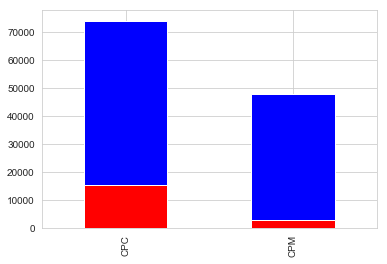

In [242]:
# better plot by day
df.ad_cost_type.value_counts().plot(kind='bar', color='blue')
df_splash_day.ad_cost_type.value_counts().plot(kind='bar',color='red')

In [243]:
df_splash_day.has_video.value_counts()

False    18227
True        32
Name: has_video, dtype: int64